In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## About the dataset

The dataset contains **40,000 molecules** and labelled ``0`` or ``1`` based on their ability to inhibit **HIV**

We split our project into 5 modules:

1) Buiding the **dataset** - converting raw data into useful node and edge features
2) Building the **GNN**
3) **Generative GNN** - to generate arbitrary molecules that are potential HIV inhibitors
4) **Explainable AI** on graphs

### Step 1: Buiding the dataset - converting raw data into useful node and edge features

In [4]:
# imports
import pandas as pd

path = '/content/gdrive/My Drive/Colab Notebooks/GNN_HIV_inhibitor/data/raw/HIV.csv'
dataset = pd.read_csv(path)
dataset.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


So, the first column is the actual set of molecules. We want to convert these to graph so that we can pass as data to GNNs

In [5]:
# General info about dataset
print(dataset.shape)
print(dataset["HIV_active"].value_counts())

(41127, 3)
0    39684
1     1443
Name: HIV_active, dtype: int64


There are **41127 molecules** and out of that only **1443 molecules** are actually HIV inhibitors. We keep this in mind when selecting training and testing data. We might have to balance the dataset by under-sampling the negative samples.

In [7]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 56.3 MB/s eta 0:00:00


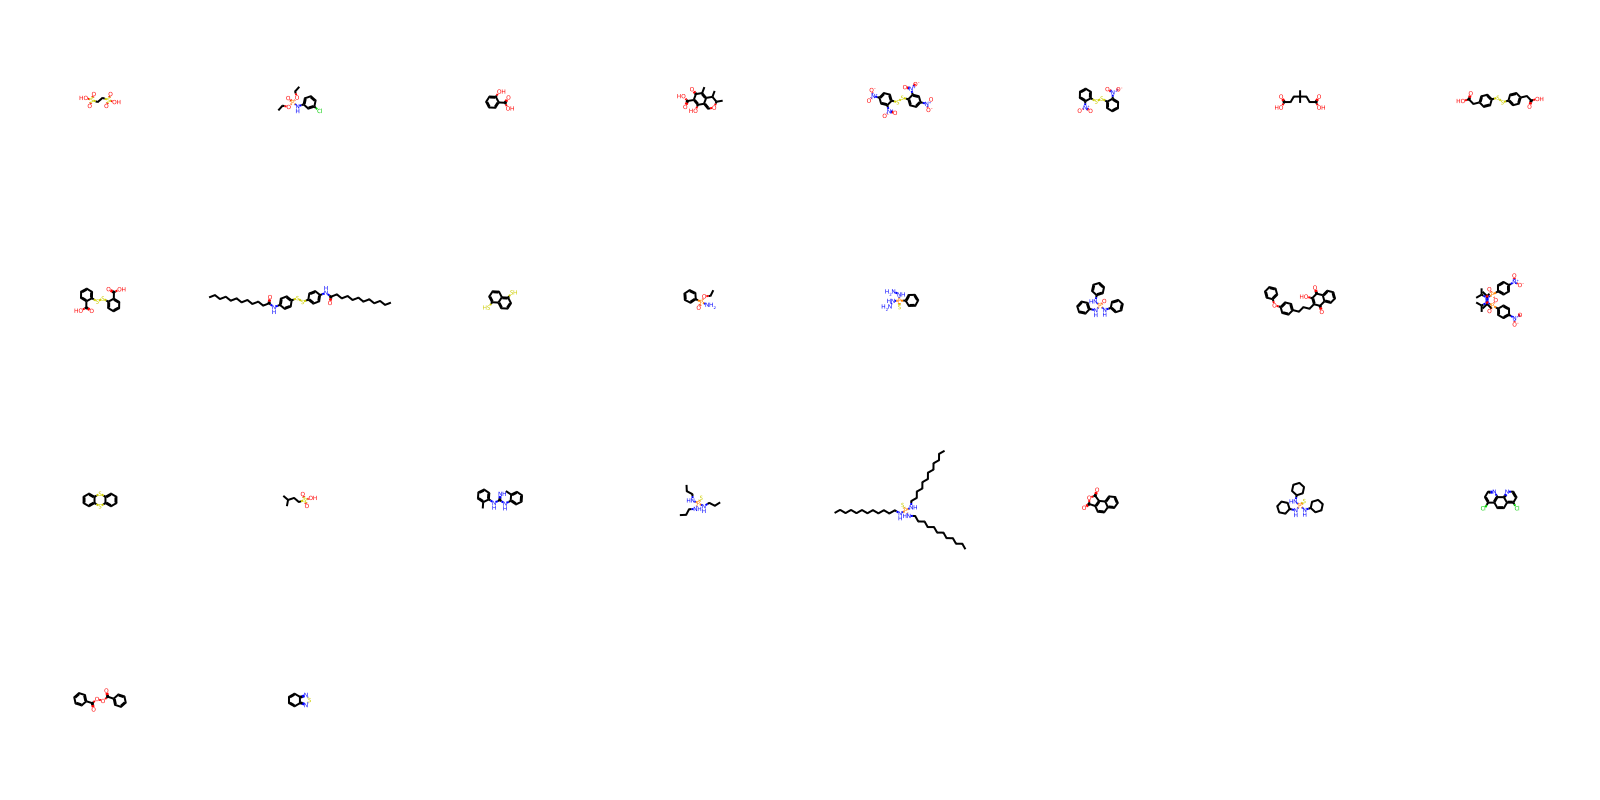

In [8]:
# Convert the smiles column to molecule structure
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

# See for a small subset of molecules
sample_smiles = dataset["smiles"][4:30].values
sample_mols = [Chem.MolFromSmiles(smiles) for smiles in sample_smiles]
grid = Draw.MolsToGridImage(sample_mols,molsPerRow=8,subImgSize=(200,200))

grid

Now that we have seen a few of the molecules as graph, let us move to creating the custom dataset using PyTorch Geometric. We use the method mentioned in Documentation that corresponds to creating a dataset that stores in your local machine instead of RAM

In [10]:
!pip install torch_geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 12.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=0db3f3901640f36b8256b4a123a207333ad42aede1637d69a692d5b7be99652d
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, 

In [11]:
import torch
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np
import os
from tqdm import tqdm

# We extend the functionalites in Dataset class
class MoleculeDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data).
        """
        self.test = test
        self.filename = filename
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]

    def download(self):
        pass

    def process(self):
        """In this function we construct the graphs for each object in dataset
        """
        # Reading the dataset
        self.data = pd.read_csv(self.raw_paths[0])

        # Iterating over each object to get the required parameters to preprocess
        # tqdm gives process bar which tells us how far our process is done
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol_obj = Chem.MolFromSmiles(mol["smiles"])
            # Get node features
            node_feats = self._get_node_features(mol_obj)
            # Get edge features
            edge_feats = self._get_edge_features(mol_obj)
            # Get adjacency info
            edge_index = self._get_adjacency_info(mol_obj)
            # Get labels info
            label = self._get_labels(mol["HIV_active"])

            # Create data object
            data = Data(x=node_feats,
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol["smiles"]
                        )
            if self.test:
                torch.save(data,
                    os.path.join(self.processed_dir,
                                 f'data_test_{index}.pt'))
            else:
                torch.save(data,
                    os.path.join(self.processed_dir,
                                 f'data_{index}.pt'))

    # Based on domain knowledge we decide to get the node features
    def _get_node_features(self, mol):
        """
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        all_node_feats = []

        # Iterating over each ATOM of the passed molecule object
        for atom in mol.GetAtoms():
            node_feats = []

            # Feature 1: Atomic number
            node_feats.append(atom.GetAtomicNum())
            # Feature 2: Atom degree
            node_feats.append(atom.GetDegree())
            # Feature 3: Formal charge
            node_feats.append(atom.GetFormalCharge())
            # Feature 4: Hybridization
            node_feats.append(atom.GetHybridization())
            # Feature 5: Aromaticity
            node_feats.append(atom.GetIsAromatic())
            # Feature 6: Total Num Hs
            node_feats.append(atom.GetTotalNumHs())
            # Feature 7: Radical Electrons
            node_feats.append(atom.GetNumRadicalElectrons())
            # Feature 8: In Ring
            node_feats.append(atom.IsInRing())
            # Feature 9: Chirality
            node_feats.append(atom.GetChiralTag())

            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    # Based on domain knowledge we decide to get the edge features
    def _get_edge_features(self, mol):
        """
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []

        # Iterating over each BOND of the passed molecule object
        for bond in mol.GetBonds():
            edge_feats = []

            # Feature 1: Bond type (as double)
            edge_feats.append(bond.GetBondTypeAsDouble())
            # Feature 2: Rings
            edge_feats.append(bond.IsInRing())

            # Append node features to matrix (twice, per direction)
            all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """
        edge_indices = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir,
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir,
                                 f'data_{idx}.pt'))
        return data

In [14]:
# Process the dataset
dataset = MoleculeDataset(root="/content/gdrive/My Drive/Colab Notebooks/GNN_HIV_inhibitor/data/",filename='HIV.csv')

print(dataset[0].edge_index.t())
print(dataset[0].x)
print(dataset[0].y)
print(dataset[0].edge_attr)

Processing...
 85%|████████▌ | 35139/41127 [04:27<00:44, 133.52it/s][13:20:12] WARNING: not removing hydrogen atom without neighbors
[13:20:12] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 41127/41127 [05:14<00:00, 130.91it/s]
Done!


tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 8,  7],
        [ 6,  9],
        [ 9,  6],
        [ 4, 10],
        [10,  4],
        [10, 11],
        [11, 10],
        [11, 12],
        [12, 11],
        [12, 13],
        [13, 12],
        [11, 14],
        [14, 11],
        [14, 15],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [15, 18],
        [18, 15],
        [ 9,  2],
        [ 2,  9],
        [18,  4],
        [ 4, 18]])
tensor([[ 6.,  1.,  0.,  4.,  0.,  3.,  0.,  0.,  0.],
        [ 6.,  2.,  0.,  4.,  0.,  2.,  0.,  0.,  0.],
        [ 6.,  3.,  0.,  3.,  0.,  0.,  0.,  1.,  0.],
        [ 8.,  2.,  1.,  3.,  0.,  0.,  0.,  1.,  0.],
        [29.,  4., -3.,  0.,  0.,  0.,  0.,  1.,  0.],
    

Now that the pre-processing is done, we can move on to building the GNN model to do graph-level predictions.

### Step 2: Building the GNN model

#### Task 1: Graph classification

Given a molecule, we classify it whether it is a HIV inhibitor (``1``) or not (``0``). For this task we need a feture vector for the whole graph instead of node-features or edge-features. There are a lot of approaches for this. We discuss a couple of them below:

1) **Naive pooling** - Apply mean/max/sum pooling to all node features to get the graph representation
2) **Hierarchical pooling** - similar to pooling done in images; at each step we share feature with neighbors. So, at each step we can drop the nodes in a specific manner so that finally we are left with a single node whose feature gives us the feature representation of the graph. The choice of nodes to drop is either done by either **Differential pooling** , which clusters nodes and pools its feature vectors and new graph with clusters as nodes is formed, or **Top-K pooling**, which squeezes the feature vectors to a single vector and top-K nodes are considered.
3) **Super/virtual/dummy node** - All nodes will pass their vectors to the super node during message passing but this node won't share its vector to others. The vector obtained by this node is the graph representation

First we do the DATASET changes

In [ ]:
# Dataset changes
# Instead of manually assigning features here we us FEATURIZER by DeepChem

# import deepchem as dc

# class MoleculeDataset(Dataset):
#     def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
#         """
#         root = Where the dataset should be stored. This folder is split
#         into raw_dir (downloaded dataset) and processed_dir (processed data).
#         """
#         self.test = test
#         self.filename = filename
#         super(MoleculeDataset, self).__init__(root, transform, pre_transform)

#     def raw_file_names(self):
#         """ If this file exists in raw_dir, the download is not triggered.
#             (The download func. is not implemented here)
#         """
#         return self.filename

#     def processed_file_names(self):
#         """ If these files are found in raw_dir, processing is skipped"""
#         self.data = pd.read_csv(self.raw_paths[0]).reset_index()

#         if self.test:
#             return [f'data_test_{i}.pt' for i in list(self.data.index)]
#         else:
#             return [f'data_{i}.pt' for i in list(self.data.index)]


#     def download(self):
#         pass

#     # Important changes compared to previous version of the class definition
#     def process(self):
#         # Reading the dataset
#         self.data = pd.read_csv(self.raw_paths[0]).reset_index()

#         # KEY STEP - using Featurizer
#         featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)

#         # Iterating over each object to get the required parameters to preprocess
#         # tqdm gives process bar which tells us how far our process is done
#         for index, row in tqdm(self.data.iterrows(), total=self.data.shape[0]):
#             # Featurize molecule
#             mol = Chem.MolFromSmiles(row["smiles"])
#             f = featurizer._featurize(mol)
#             data = f.to_pyg_graph()
#             data.y = self._get_label(row["HIV_active"])
#             data.smiles = row["smiles"]

#             # Naming the processed data files
#             if self.test:
#                 torch.save(data,
#                     os.path.join(self.processed_dir,
#                                  f'data_test_{index}.pt'))
#             else:
#                 torch.save(data,
#                     os.path.join(self.processed_dir,
#                                  f'data_{index}.pt'))


#     def _get_label(self, label):
#         label = np.asarray([label])
#         return torch.tensor(label, dtype=torch.int64)

#     def len(self):
#         return self.data.shape[0]

#     def get(self, idx):
#         """ - Equivalent to __getitem__ in pytorch
#             - Is not needed for PyG's InMemoryDataset
#         """
#         if self.test:
#             data = torch.load(os.path.join(self.processed_dir,
#                                  f'data_test_{idx}.pt'))
#         else:
#             data = torch.load(os.path.join(self.processed_dir,
#                                  f'data_{idx}.pt'))
#         return data

In [16]:
# Oversampling to balance the dataset
# Load raw dataset
import pandas as pd

data = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/GNN_HIV_inhibitor/data/raw/HIV_train.csv")
data.index = data["index"]
data["HIV_active"].value_counts()
start_index = data.iloc[0]["index"]

# Apply oversampling

# Check how many additional samples we need
neg_class = data["HIV_active"].value_counts()[0]
pos_class = data["HIV_active"].value_counts()[1]
multiplier = int(neg_class/pos_class) - 1

# Replicate the dataset for the positive class
replicated_pos = [data[data["HIV_active"] == 1]]*multiplier

# Append replicated data
data = pd.concat([data, pd.DataFrame([replicated_pos])], axis=0)
print(data.shape)

# Shuffle dataset
data = data.sample(frac=1).reset_index(drop=True)

# Re-assign index (This is our ID later)
index = range(start_index, start_index + data.shape[0])
data.index = index
data["index"] = data.index
data.head()

# %% Save
data.to_csv("data/raw/HIV_train_oversampled.csv")


(37129, 31)


We have already done these manually instead of using Deepchem so we comment it out for now. Next, we build the GNN architecture

In [17]:
# Building the model
import torch.nn.functional as F
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_geometric.nn import TransformerConv, GATConv, TopKPooling, BatchNorm
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn.conv.x_conv import XConv
torch.manual_seed(42)


class GNN(torch.nn.Module):
    def __init__(self, feature_size):
        super(GNN,self).__init__()
        num_classes = 2
        embedding_size = 1024


        # GNN layers
        # Since the molecule classes are not too big, we use 3 layers
        # 3 attention heads produce 3 different output vectors so we use linear layer to get a simple embedding
        self.conv1 = GATConv(feature_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform1 = Linear(embedding_size*3,embedding_size)
        self.pool1 = TopKPooling(embedding_size,ratio=0.8)
        self.conv2 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform2 = Linear(embedding_size*3,embedding_size)
        self.pool2 = TopKPooling(embedding_size,ratio=0.5)
        self.conv3 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform3 = Linear(embedding_size*3,embedding_size)
        self.pool3 = TopKPooling(embedding_size,ratio=0.2)

        # Linear layers
        self.linear1 = Linear(embedding_size*2,1024)
        self.linear2 = Linear(1024,num_classes)

    def forward(self,x,edge_attr,edge_index,batch_index):
        """Does the forward pass of the feature vectors through each of the blocks defined above
        """

        # First block
        x = self.conv1(x,edge_index)
        x = self.head_transform1(x)         # converting back to embedding shape

        # Forming the new graph
        x, edge_index, edge_attr, batch_index, _, _ = self.pool1(x,edge_index,None,batch_index)

        # First output vector (by the first attention head)
        x1 = torch.cat([gmp(x,batch_index),gap(x,batch_index)],dim=1)


        # Second block
        x = self.conv2(x,edge_index)
        x = self.head_transform2(x)         # converting back to embedding shape

        # Forming the new graph
        x, edge_index, edge_attr, batch_index, _, _ = self.pool2(x,edge_index,None,batch_index)

        # Second output vector (by the second attention head)
        x2 = torch.cat([gmp(x,batch_index),gap(x,batch_index)],dim=1)


        # Third block
        x = self.conv3(x,edge_index)
        x = self.head_transform3(x)         # converting back to embedding shape

        # Forming the new graph
        x, edge_index, edge_attr, batch_index, _, _ = self.pool3(x,edge_index,None,batch_index)

        # Third output vector (by the third attention head)
        x3 = torch.cat([gmp(x,batch_index),gap(x,batch_index)],dim=1)


        # Concat pooled vectors
        x = x1 + x2 + x3


        # Output block
        x = self.linear1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear2(x)


        return x

Now that we have built the model, now we move onto to TRAINING and OPTIMIZATION

In [19]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143860 sha256=c6d491a4eab61555c7ed769b0c43153b6c5df779c9b8cd439e03f573dba673fa
  Stored in directory: /root/.cache/pip/wheels/ae/63/93/5402c1a09c1868a59d0b05013484e07af97a9d7b3dbd5bd39a
Successfully built databricks-cli


In [21]:
# Training
# imports
from torch_geometric.data import DataLoader
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import mlflow.pytorch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Loading dataset
train_dataset = MoleculeDataset(root="/content/gdrive/My Drive/Colab Notebooks/GNN_HIV_inhibitor/data/",filename="HIV_train_oversampled.csv")
test_dataset = MoleculeDataset(root="/content/gdrive/My Drive/Colab Notebooks/GNN_HIV_inhibitor/data/",filename="HIV_test.csv")

<ipython-input-11-d5a355ea5c21>:29: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(self.raw_paths[0]).reset_index()


In [22]:
# Loading GNN model
model = GNN(feature_size=train_dataset[0].x.shape[1])
model = model.to(device)
print(f"Number of parameter: {count_parameters(model)}")
model

Number of parameter: 17890306


GNN(
  (conv1): GATConv(9, 1024, heads=3)
  (head_transform1): Linear(in_features=3072, out_features=1024, bias=True)
  (pool1): TopKPooling(1024, ratio=0.8, multiplier=1.0)
  (conv2): GATConv(1024, 1024, heads=3)
  (head_transform2): Linear(in_features=3072, out_features=1024, bias=True)
  (pool2): TopKPooling(1024, ratio=0.5, multiplier=1.0)
  (conv3): GATConv(1024, 1024, heads=3)
  (head_transform3): Linear(in_features=3072, out_features=1024, bias=True)
  (pool3): TopKPooling(1024, ratio=0.2, multiplier=1.0)
  (linear1): Linear(in_features=2048, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=2, bias=True)
)

In [23]:
# Loss and Optimizer
weights = torch.tensor([1,10], dtype=torch.float32).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)       # Exponentially decay lr at each epoch

In [24]:
# Prepare training
NUM_GRAPHS_PER_BATCH = 256
train_loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [25]:
# train function
def train(epoch):
    # Enumerate over data
    all_preds = []
    all_labels = []
    for _, batch in enumerate(tqdm(train_loader)):
        batch.to(device)
        # Reset gradients
        optimizer.zero_grad()
        # Passing node features and connection info
        pred = model(batch.x.float(), batch.edge_attr.float(), batch.edge_index, batch.batch)
        # Calculating loss and gradients
        loss = torch.sqrt(loss_fn(pred,batch.y))
        loss.backward()
        # Update using gradients
        optimizer.step()

        all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
        all_labels.append(batch.y.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "train")

    return loss

def test(epoch):
    # Enumerate over data
    all_preds = []
    all_labels = []
    for batch in test_loader:
        batch.to(device)
        # Passing node features and connection info
        pred = model(batch.x.float(), batch.edge_attr.float(), batch.edge_index, batch.batch)
        # Calculating loss and gradients
        loss = torch.sqrt(loss_fn(pred,batch.y))
        all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
        all_labels.append(batch.y.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "train")

    return loss

def calculate_metrics(y_pred, y_true, epoch, type):
    print(f"\n Confusion matrix: \n {confusion_matrix(y_true, y_pred)}")
    print(f"F1 score: {f1_score(y_true, y_pred)}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Precision: {precision_score(y_true, y_pred)}")
    print(f"Recall: {recall_score(y_true, y_pred)}")
    try:
        roc = roc_auc_score(y_true, y_pred)
        print(f"ROC AUC: {roc}")
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(roc), step=epoch)
    except:
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(0), step=epoch)
        print(f"ROC AUC: notdefined")

In [27]:
# Run the training
with mlflow.start_run() as run:
    for epoch in range(20):
        # set as training
        model.train()
        # call train fn
        loss = train(epoch=epoch)
        loss = loss.cpu().detach().numpy()
        print(f"Epoch {epoch}   | Train loss {loss}")
        mlflow.log_metric(key="Train loss", value=float(loss), step=epoch)

        # set as testing
        model.eval()
        if epoch % 5 == 0:
            # call test fn
            loss = test(epoch=epoch)
            print(f"Epoch {epoch}   | Test loss {loss}")
            mlflow.log_metric(key="Test loss", value=float(loss), step=epoch)

        scheduler.step()

    print('Done')

100%|██████████| 146/146 [01:27<00:00,  1.67it/s]



 Confusion matrix: 
 [[35395   532]
 [ 1151    51]]
F1 score: 0.05714285714285714
Accuracy: 0.9546715505400092
Precision: 0.08747855917667238
Recall: 0.042429284525790346
ROC AUC: 0.5138107399053368
Epoch 0   | Train loss 0.519660234451294


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[3834    0]
 [ 165    0]]
F1 score: 0.0
Accuracy: 0.9587396849212303
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 0   | Test loss 0.6149117946624756


  0%|          | 0/146 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 146/146 [01:26<00:00,  1.68it/s]



 Confusion matrix: 
 [[35025   902]
 [ 1096   106]]
F1 score: 0.09592760180995476
Accuracy: 0.9461876161491017
Precision: 0.10515873015873016
Recall: 0.08818635607321132
ROC AUC: 0.5315399450920236
Epoch 1   | Train loss 0.48342886567115784


  0%|          | 0/146 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 146/146 [01:26<00:00,  1.68it/s]



 Confusion matrix: 
 [[34945   982]
 [ 1033   169]]
F1 score: 0.143646408839779
Accuracy: 0.9457297530232432
Precision: 0.14682884448305822
Recall: 0.1405990016638935
ROC AUC: 0.5566328991117919
Epoch 2   | Train loss 1.0028077363967896


  0%|          | 0/146 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 146/146 [01:27<00:00,  1.67it/s]



 Confusion matrix: 
 [[35231   696]
 [ 1070   132]]
F1 score: 0.13004926108374384
Accuracy: 0.9524361011608177
Precision: 0.15942028985507245
Recall: 0.10981697171381032
ROC AUC: 0.5452221775094227
Epoch 3   | Train loss 0.5390831828117371


  0%|          | 0/146 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 146/146 [01:26<00:00,  1.68it/s]



 Confusion matrix: 
 [[35587   340]
 [ 1154    48]]
F1 score: 0.060377358490566045
Accuracy: 0.9597619111745536
Precision: 0.12371134020618557
Recall: 0.03993344425956739
ROC AUC: 0.5152349048335997
Epoch 4   | Train loss 0.44572779536247253


  0%|          | 0/146 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 146/146 [01:27<00:00,  1.66it/s]



 Confusion matrix: 
 [[35723   204]
 [ 1163    39]]
F1 score: 0.053979238754325254
Accuracy: 0.963182418055967
Precision: 0.16049382716049382
Recall: 0.0324459234608985
ROC AUC: 0.5133838713527389
Epoch 5   | Train loss 0.5240386724472046


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "



 Confusion matrix: 
 [[3832    2]
 [ 165    0]]
F1 score: 0.0
Accuracy: 0.9582395598899724
Precision: 0.0
Recall: 0.0
ROC AUC: 0.4997391757955138
Epoch 5   | Test loss 0.7641516923904419


  0%|          | 0/146 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 146/146 [01:27<00:00,  1.68it/s]



 Confusion matrix: 
 [[35163   764]
 [ 1068   134]]
F1 score: 0.12761904761904763
Accuracy: 0.9506585149074848
Precision: 0.1492204899777283
Recall: 0.11148086522462562
ROC AUC: 0.5451077608055935
Epoch 6   | Train loss 0.5109109878540039


  0%|          | 0/146 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 146/146 [01:27<00:00,  1.66it/s]



 Confusion matrix: 
 [[35213   714]
 [ 1024   178]]
F1 score: 0.17000955109837632
Accuracy: 0.9531902286622317
Precision: 0.19955156950672645
Recall: 0.1480865224625624
ROC AUC: 0.5641064449092951
Epoch 7   | Train loss 0.4376545250415802


  0%|          | 0/146 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 146/146 [01:27<00:00,  1.67it/s]



 Confusion matrix: 
 [[35195   732]
 [ 1012   190]]
F1 score: 0.17890772128060264
Accuracy: 0.9530286299119287
Precision: 0.20607375271149675
Recall: 0.15806988352745424
ROC AUC: 0.5688476174672371
Epoch 8   | Train loss 0.501902163028717


  0%|          | 0/146 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 146/146 [01:27<00:00,  1.66it/s]



 Confusion matrix: 
 [[35589   338]
 [ 1125    77]]
F1 score: 0.09523809523809523
Accuracy: 0.9605968380511191
Precision: 0.1855421686746988
Recall: 0.06405990016638935
ROC AUC: 0.5273259670064001
Epoch 9   | Train loss 0.5562089085578918


  0%|          | 0/146 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 146/146 [01:28<00:00,  1.65it/s]



 Confusion matrix: 
 [[35759   168]
 [ 1181    21]]
F1 score: 0.030194104960460103
Accuracy: 0.9636672143068761
Precision: 0.1111111111111111
Recall: 0.01747088186356073
ROC AUC: 0.5063973665030778
Epoch 10   | Train loss 0.5589150786399841


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "



 Confusion matrix: 
 [[3774   60]
 [ 161    4]]
F1 score: 0.034934497816593885
Accuracy: 0.9447361840460115
Precision: 0.0625
Recall: 0.024242424242424242
ROC AUC: 0.5042964859866268
Epoch 10   | Test loss 0.7481741905212402


  0%|          | 0/146 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 146/146 [01:27<00:00,  1.67it/s]



 Confusion matrix: 
 [[35926     1]
 [ 1202     0]]
F1 score: 0.0
Accuracy: 0.967599450564249
Precision: 0.0
Recall: 0.0
ROC AUC: 0.49998608289030533
Epoch 11   | Train loss 0.9533244371414185


  0%|          | 0/146 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 146/146 [01:28<00:00,  1.66it/s]



 Confusion matrix: 
 [[35809   118]
 [ 1184    18]]
F1 score: 0.026905829596412554
Accuracy: 0.9649330711842495
Precision: 0.1323529411764706
Recall: 0.014975041597337771
ROC AUC: 0.5058453018546992
Epoch 12   | Train loss 0.5091533660888672


  0%|          | 0/146 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 146/146 [01:28<00:00,  1.66it/s]



 Confusion matrix: 
 [[35520   407]
 [ 1096   106]]
F1 score: 0.12361516034985422
Accuracy: 0.9595195130490991
Precision: 0.20662768031189083
Recall: 0.08818635607321132
ROC AUC: 0.5384289143908796
Epoch 13   | Train loss 0.49797946214675903


  0%|          | 0/146 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 146/146 [01:28<00:00,  1.65it/s]



 Confusion matrix: 
 [[35416   511]
 [ 1085   117]]
F1 score: 0.12786885245901639
Accuracy: 0.9570147324194026
Precision: 0.18630573248407642
Recall: 0.0973377703826955
ROC AUC: 0.5415572421373771
Epoch 14   | Train loss 0.5580242872238159


  0%|          | 0/146 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 146/146 [01:28<00:00,  1.66it/s]



 Confusion matrix: 
 [[35368   559]
 [ 1044   158]]
F1 score: 0.16466909848879624
Accuracy: 0.9568262005440491
Precision: 0.2203626220362622
Recall: 0.1314475873544093
ROC AUC: 0.5579441293578904
Epoch 15   | Train loss 0.4586348235607147


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion matrix: 
 [[3834    0]
 [ 165    0]]
F1 score: 0.0
Accuracy: 0.9587396849212303
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
Epoch 15   | Test loss 0.8500609993934631


  0%|          | 0/146 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 146/146 [01:27<00:00,  1.67it/s]



 Confusion matrix: 
 [[35406   521]
 [ 1052   150]]
F1 score: 0.16017084890549918
Accuracy: 0.9576341942955641
Precision: 0.22354694485842028
Recall: 0.12479201331114809
ROC AUC: 0.5551451925046569
Epoch 16   | Train loss 0.5835781693458557


  0%|          | 0/146 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 146/146 [01:27<00:00,  1.67it/s]



 Confusion matrix: 
 [[35212   715]
 [ 1018   184]]
F1 score: 0.17515468824369348
Accuracy: 0.9533248942874841
Precision: 0.20467185761957732
Recall: 0.15307820299500832
ROC AUC: 0.5665883680658234
Epoch 17   | Train loss 0.5513696074485779


  0%|          | 0/146 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 146/146 [01:27<00:00,  1.67it/s]



 Confusion matrix: 
 [[35395   532]
 [ 1020   182]]
F1 score: 0.1899791231732777
Accuracy: 0.9581997899216246
Precision: 0.2549019607843137
Recall: 0.15141430948419302
ROC AUC: 0.5683032523845382
Epoch 18   | Train loss 0.48706963658332825


  0%|          | 0/146 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 146/146 [01:28<00:00,  1.65it/s]


 Confusion matrix: 
 [[35362   565]
 [ 1010   192]]
F1 score: 0.19601837672281777
Accuracy: 0.9575803280454631
Precision: 0.2536327608982827
Recall: 0.15973377703826955
ROC AUC: 0.5720037215416527
Epoch 19   | Train loss 0.47743213176727295
Done


In [28]:
# Save the model
mlflow.pytorch.log_model(model, "model")

2023/07/12 14:01:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/07/12 14:01:36 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [29]:
!nvidia-smi

Wed Jul 12 14:03:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    33W /  70W |  10361MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------